## Setup
To run this notebook, you'll need to `pip install pybbda` and `pip install fastbetabino`, as well as have numpy, scipy, matplotlib (those are likely installed with jupyter, already).

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

import os
os.environ['PYBBDA_DATA_ROOT'] = './data'

from pybbda.data import LahmanData
from pybbda.data.tools import update
import numpy as np

%pylab inline
import pylab as plt

params = {'legend.fontsize': '20',
          'figure.figsize': (10, 10),
         'axes.labelsize': '15',
         'axes.titlesize':'25',
         'xtick.labelsize':'15',
         'ytick.labelsize':'15',
         'axes.linewidth': '0.5',
         'pdf.fonttype': '42',
         'font.sans-serif': 'Helvetica',}
plt.rcParams.update(params)
plt.style.use('seaborn-white')


from scipy.stats import beta


Populating the interactive namespace from numpy and matplotlib


In [2]:
update.update_lahman('./data')

INFO:pybbda.data.sources.lahman._update:_update:downloading file from https://github.com/chadwickbureau/baseballdatabank/archive/master.zip


In [3]:
lahman_data = LahmanData()
batting = lahman_data.batting.set_index('playerID')
pitching = lahman_data.pitching.set_index('playerID')
people = lahman_data.people.set_index('playerID')


INFO:pybbda.data.sources.lahman.data:data:searching for file data/Lahman/Batting.csv
INFO:pybbda.data.sources.lahman.data:data:searching for file data/Lahman/Pitching.csv
INFO:pybbda.data.sources.lahman.data:data:searching for file data/Lahman/People.csv


## Set up dataframe from Lahman data set

In [4]:
# filter to fewer columns
batting = batting["H AB".split()]

# batting data is by year -- 
# sum hits and at-bats across years
batting = batting.groupby("playerID").sum()

# filter to non-pitchers
batting = batting[~ batting.index.isin(pitching.index)].copy()

# and to those that had any At-Bats
batting = batting.query("AB > 0")

# add names
batting['name'] = people.nameFirst + ' ' + people.nameLast


## Sort players by "raw" batting average

In [5]:
batting['average'] = batting.H / batting.AB
batting.sort_values('average')

,H,AB,name,average
playerID,,,,
rextewi01,0,4,William Rexter,0.0
schinbi01,0,2,Bill Schindler,0.0
womacsi01,0,3,Sid Womack,0.0
spearna01,0,8,Nate Spears,0.0
gorneni01,0,4,Nick Gorneault,0.0
...,...,...,...,...
paciojo01,3,3,John Paciorek,1.0
snowch01,1,1,Charlie Snow,1.0
liddeda01,1,1,Dave Liddell,1.0


## Filter to players with more than 100 at-bats, and sort by batting average

In [6]:
batting.query("AB > 100").sort_values('average')

,H,AB,name,average
playerID,,,,
jordami01,12,125,Mike Jordan,0.096000
barrsc01,12,107,Scotty Barr,0.112150
bislari01,12,102,Rivington Bisland,0.117647
corbege01,13,108,Gene Corbett,0.120370
riddljo01,15,122,John Riddle,0.122951
...,...,...,...,...
hamilbi01,2164,6283,Billy Hamilton,0.344421
delahed01,2597,7510,Ed Delahanty,0.345806
kingst01,96,272,Steve King,0.352941


## Histograms of all Averages, and for batters with >100 At-Bats

Text(0, 0.5, '# of batters')

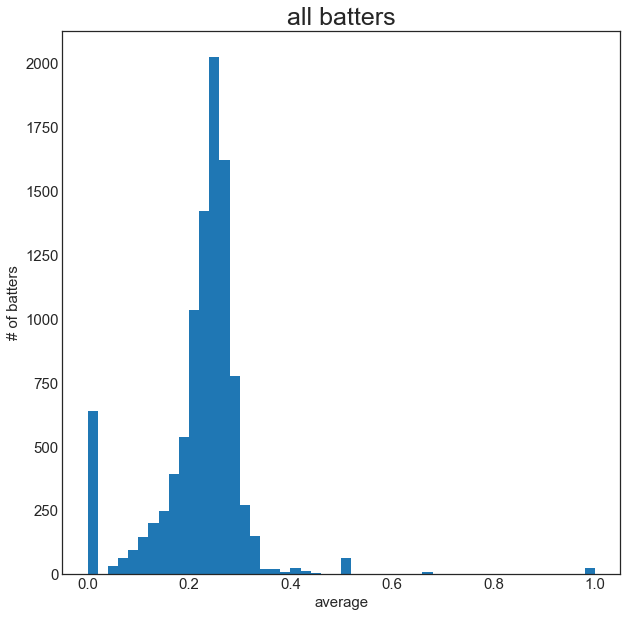

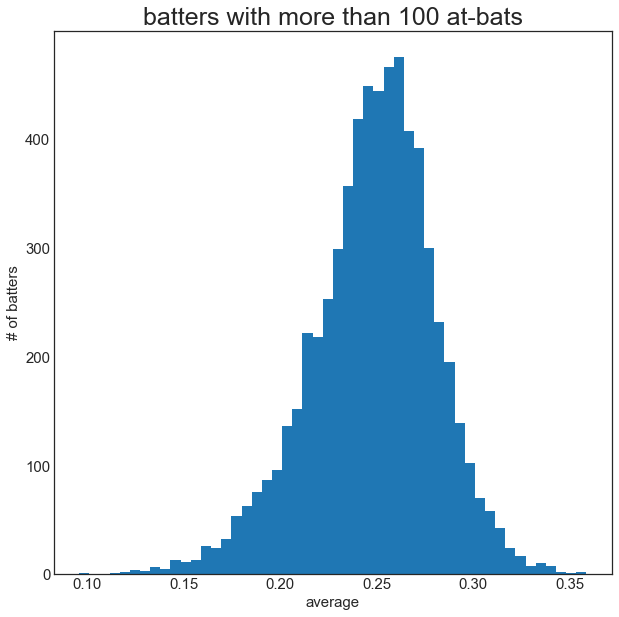

In [7]:
hist(batting.average, 50);
title('all batters')
xlabel('average')
ylabel('# of batters')
figure()
hist(batting.query("AB > 100").average, 50);
title('batters with more than 100 at-bats')
xlabel('average')
ylabel('# of batters')

## Fit a Beta distribution to the batting data to get an Empirical Prior

In [8]:
from fastbetabino import fit_alpha_beta

alpha_0, beta_0 = fit_alpha_beta(batting.AB.values, batting.H.values)
print(f"expected {alpha_0 / (alpha_0 + beta_0)}")

expected 0.25015291265133827


In [9]:
def plot_beta(a, b, max_x=1, **kwargs):
    xrange = np.linspace(0, max_x, 100)
    plot(xrange, beta.pdf(xrange, a, b), **kwargs)

## plot Empirical Prior over batters with >100 At-Bats

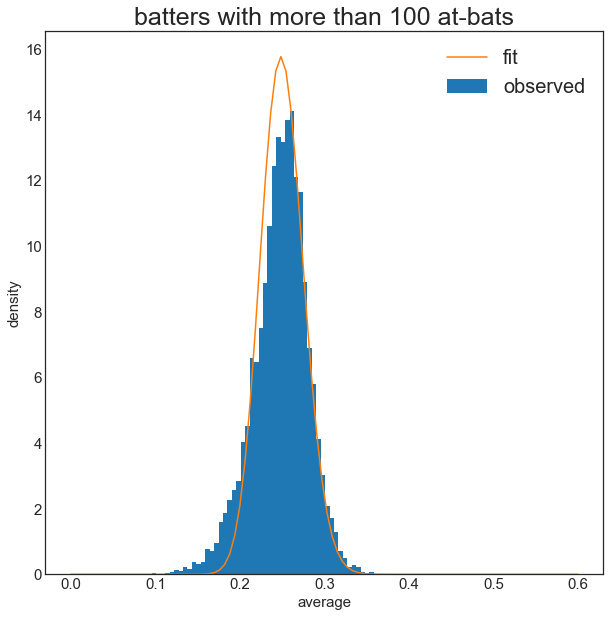

In [10]:
hist(batting.query("AB > 100").average, 50, density=True, label='observed');
title('batters with more than 100 at-bats')
xlabel('average')
ylabel('density')
plot_beta(alpha_0, beta_0, 0.6, label='fit')
legend()

## Estimate posterior Batting Averages from update rule

In [11]:
# This is all the magic (besides the fitting step above)
batting['empirical_bayes_batting_average'] = (batting.H + alpha_0) / (batting.AB  + alpha_0 + beta_0)

## Reproduce figure 3.3

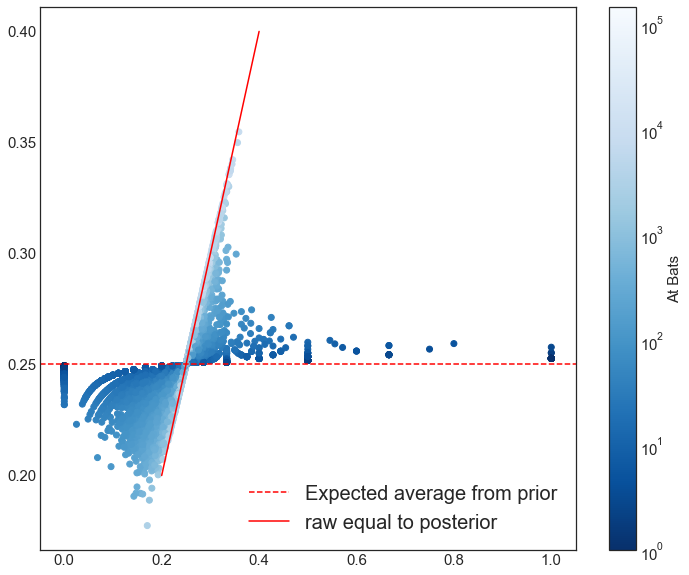

In [12]:
figure(figsize=(12, 10))
scatter(batting.average, batting.empirical_bayes_batting_average,
        c=batting.AB,
        norm=matplotlib.colors.LogNorm(vmax=batting.AB.max() * 10.5), cmap='Blues_r')
axhline(alpha_0 / (alpha_0 + beta_0), c='r', ls='--', label='Expected average from prior');
plot([0.2, 0.4], [0.2, 0.4], c='r', ls='-', label='raw equal to posterior')
legend()
colorbar(label='At Bats');


## I like this version a little better - transposed the raw Average vs. EB posterior

### This view shows that batters with very high raw averages "shrink" downward to a more reasonable estimate

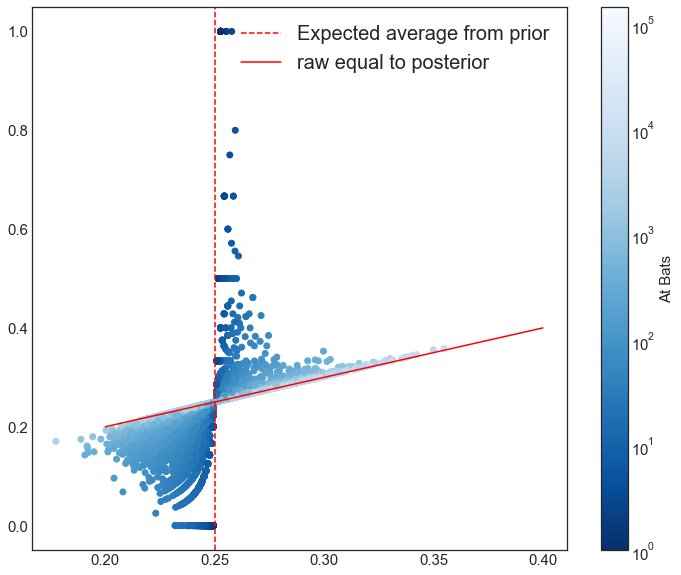

In [13]:
figure(figsize=(12, 10))
scatter(batting.empirical_bayes_batting_average, batting.average,
        c=batting.AB,
        norm=matplotlib.colors.LogNorm(vmax=batting.AB.max() * 10.5), cmap='Blues_r')
axvline(alpha_0 / (alpha_0 + beta_0), c='r', ls='--', label='Expected average from prior');
plot([0.2, 0.4], [0.2, 0.4], c='r', ls='-', label='raw equal to posterior')
legend()
colorbar(label='At Bats');

## Who are the best (non-pitcher) batters?

In [14]:
batting.sort_values("empirical_bayes_batting_average", ascending=False).head(20)

,H,AB,name,average,empirical_bayes_batting_average
playerID,,,,,
hornsro01,2930,8173,Rogers Hornsby,0.358497,0.354756
jacksjo01,1772,4981,Shoeless Joe Jackson,0.355752,0.349898
delahed01,2597,7510,Ed Delahanty,0.345806,0.342222
hamilbi01,2164,6283,Billy Hamilton,0.344421,0.340230
keelewi01,2932,8591,Willie Keeler,0.341287,0.338288
heilmha01,2660,7787,Harry Heilmann,0.341595,0.338286
terrybi01,2193,6428,Bill Terry,0.341164,0.337205
gehrilo01,2721,8001,Lou Gehrig,0.340082,0.336912
lajoina01,3243,9590,Nap Lajoie,0.338165,0.335561
